<a href="https://colab.research.google.com/github/lamazakaria/Brain-Tumor-Detection/blob/main/Brain_tumor_detection_using_UNET_lama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os

get_ipython().run_line_magic('run', '"/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection/inception_unet.ipynb"')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from inception_unet import bulid_model


Shape before: (2, 2)
Shape after: (2, 2, 1)
[[[1]
  [2]]

 [[3]
  [4]]]


## Dice loss

In [18]:
def dice_coeff(y_true,y_hat):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_hat = tf.keras.layers.Flatten()(y_hat)
    intersection = tf.reduce_sum(y_hat*y_true)
    return (2*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_hat))



In [19]:
def dice_loss(y_true,y_hat):
    return 1 - dice_coeff(y_true,y_hat)

## Read data


In [20]:
path = "/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-Detection/archive (4)"

In [22]:
epochs = 100
batch_size = 16
lr = 1e-3
W, H =256,256

In [23]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    if len(images) < 3 or len(masks) < 3:
        raise ValueError("Insufficient data for splitting. Make sure you have at least three samples.")
    train_x, test_x, train_y, test_y = train_test_split(images[:3064], masks, test_size=split, random_state=42)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=split, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [24]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(path)
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
#test_dataset = tf_dataset(test_x,test_y,batch = batch_size)



In [25]:
test_dataset = tf_dataset(test_x,test_y,batch = batch_size)



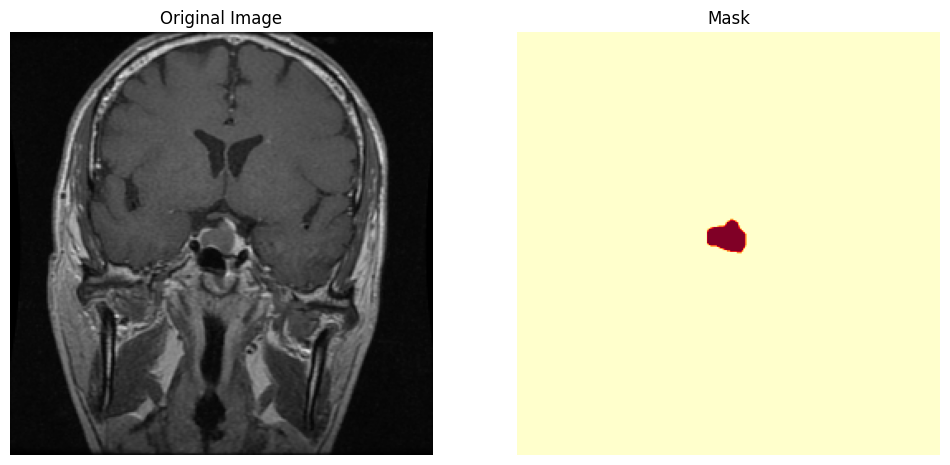

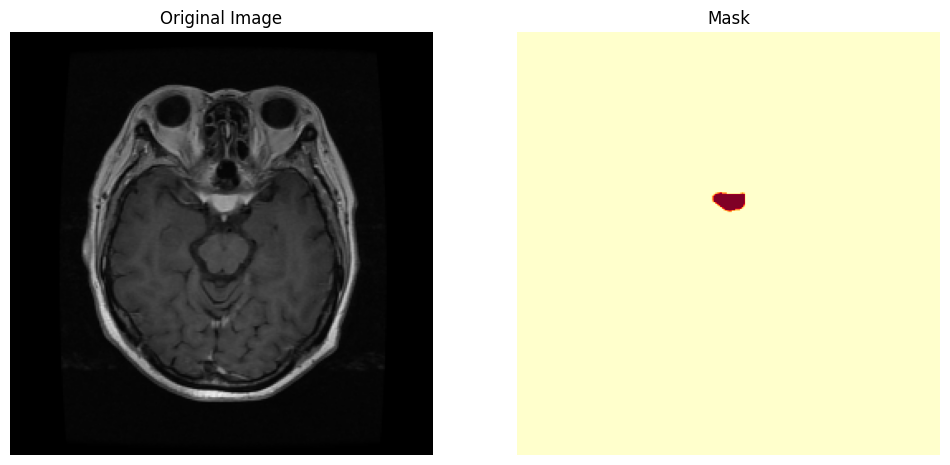

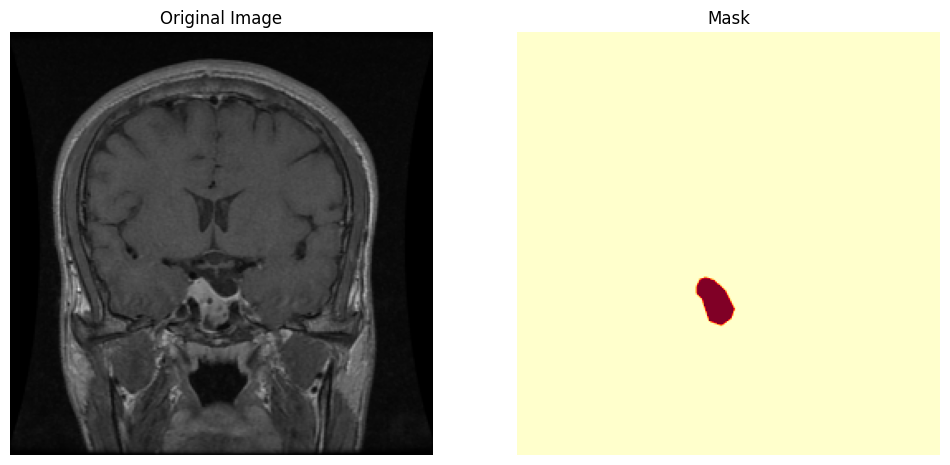

In [26]:
import matplotlib.pyplot as plt
import numpy as np



# Create a tf.data.Dataset for visualization
visualization_dataset = tf_dataset(train_x[:3], train_y[:3], batch=3)

# Iterate through the dataset and visualize images and masks
for batch in visualization_dataset:
    images, masks = batch
    for i in range(images.shape[0]):
        plt.figure(figsize=(12, 6))

        # Visualize the original image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis("off")

        # Visualize the corresponding mask
        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(masks[i]), cmap='YlOrRd')  # Assuming masks are grayscale

        plt.title("Mask")
        plt.axis("off")

        plt.show()


## Model
**bold text**


In [27]:
from tensorflow.keras.metrics import Recall, Precision,F1Score


model = bulid_model()
# Define your metrics
recall = Recall(name='recall')
precision = Precision(name='precision')

# Compile your model
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coeff, 'accuracy', recall, precision])

(None, 128, 128, 128) (None, 64, 64, 256) (None, 32, 32, 512) (None, 16, 16, 1024) (None, 16, 16, 2048) (None, 16, 16, 2048)
(None, 128, 128, 128)
(None, 256, 256, 1)


In [28]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]


In [29]:
model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/100
123/123 [==============================] - 1392s 11s/step - loss: 0.6850 - dice_coeff: 0.3171 - accuracy: 0.9207 - recall: 0.4437 - precision: 0.1004 - val_loss: 0.9628 - val_dice_coeff: 0.0371 - val_accuracy: 0.1270 - val_recall: 1.0000 - val_precision: 0.0196 - lr: 0.0010
Epoch 2/100
123/123 [==============================] - 103s 836ms/step - loss: 0.5036 - dice_coeff: 0.4978 - accuracy: 0.9833 - recall: 0.4675 - precision: 0.5352 - val_loss: 0.9425 - val_dice_coeff: 0.0574 - val_accuracy: 0.4999 - val_recall: 0.8970 - val_precision: 0.0305 - lr: 0.0010
Epoch 3/100
123/123 [==============================] - 215s 2s/step - loss: 0.4378 - dice_coeff: 0.5634 - accuracy: 0.9853 - recall: 0.5357 - precision: 0.5997 - val_loss: 0.8448 - val_dice_coeff: 0.1546 - val_accuracy: 0.9453 - val_recall: 0.2986 - val_precision: 0.1100 - lr: 0.0010
Epoch 4/100
123/123 [==============================] - 104s 846ms/step - loss: 0.4344 - dice_coeff: 0.5670 - accuracy: 0.9855 - recall: 0.53

In [30]:
history = model.history.history
print(list(history.keys()))


['loss', 'dice_coeff', 'accuracy', 'recall', 'precision', 'val_loss', 'val_dice_coeff', 'val_accuracy', 'val_recall', 'val_precision', 'lr']


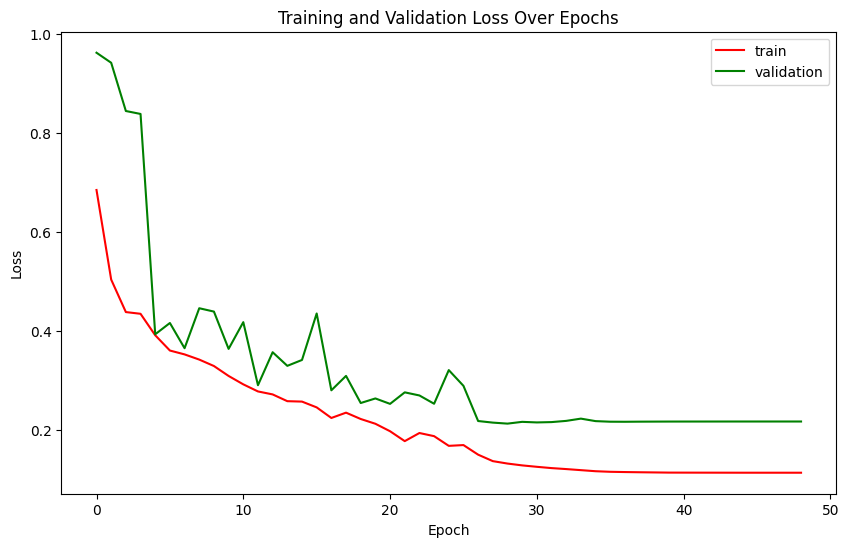

dict_keys(['loss', 'dice_coeff', 'accuracy', 'recall', 'precision', 'val_loss', 'val_dice_coeff', 'val_accuracy', 'val_recall', 'val_precision', 'lr'])


In [31]:
history = model.history.history  # Access the history attribute

# Create a new figure and plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='train', color='r')
plt.plot(history['val_loss'], label='validation', color='g')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()
print(history.keys())

In [32]:
result= model.evaluate(test_dataset)

print(f"Test Loss:{result[0]}")
print(f"Test dice coeff:{result[1]}")
print(f"Test Accuarcy:{result[2]*100} %")
print(f"Test Recall: {result[3]}")
print(f"Test Precision: {result[4]}")
# Calculate F1 score
f1_score = 2 * ((result[3] * result[4]) / (result[3] + result[4]))
print(f"Test F1 Score: {f1_score}")


39/39 [==============================] - 330s 8s/step - loss: 0.2010 - dice_coeff: 0.7981 - accuracy: 0.9929 - recall: 0.7486 - precision: 0.8613
Test Loss:0.2010236233472824
Test dice coeff:0.7980759739875793
Test Accuarcy:99.29243922233582 %
Test Recall: 0.7485610246658325
Test Precision: 0.8612547516822815
Test F1 Score: 0.8009633759213358


1/1 [==============================] - 2s 2s/step
[1]
1/1 [==============================] - 0s 56ms/step
[1]
1/1 [==============================] - 0s 58ms/step
[1]
1/1 [==============================] - 0s 55ms/step
[1]
1/1 [==============================] - 0s 58ms/step
[0]
1/1 [==============================] - 0s 58ms/step
[1]
1/1 [==============================] - 0s 59ms/step
[1]
1/1 [==============================] - 0s 71ms/step
[1]
1/1 [==============================] - 0s 59ms/step
[1]
1/1 [==============================] - 0s 194ms/step
[0]
1/1 [==============================] - 0s 54ms/step
[1]
1/1 [==============================] - 0s 57ms/step
[0]
1/1 [==============================] - 0s 46ms/step
[0]
1/1 [==============================] - 0s 68ms/step
[1]
1/1 [==============================] - 0s 185ms/step
[0]
1/1 [==============================] - 0s 94ms/step
[1]
1/1 [==============================] - 0s 129ms/step
[0]
1/1 [==============================] - 0s 107ms

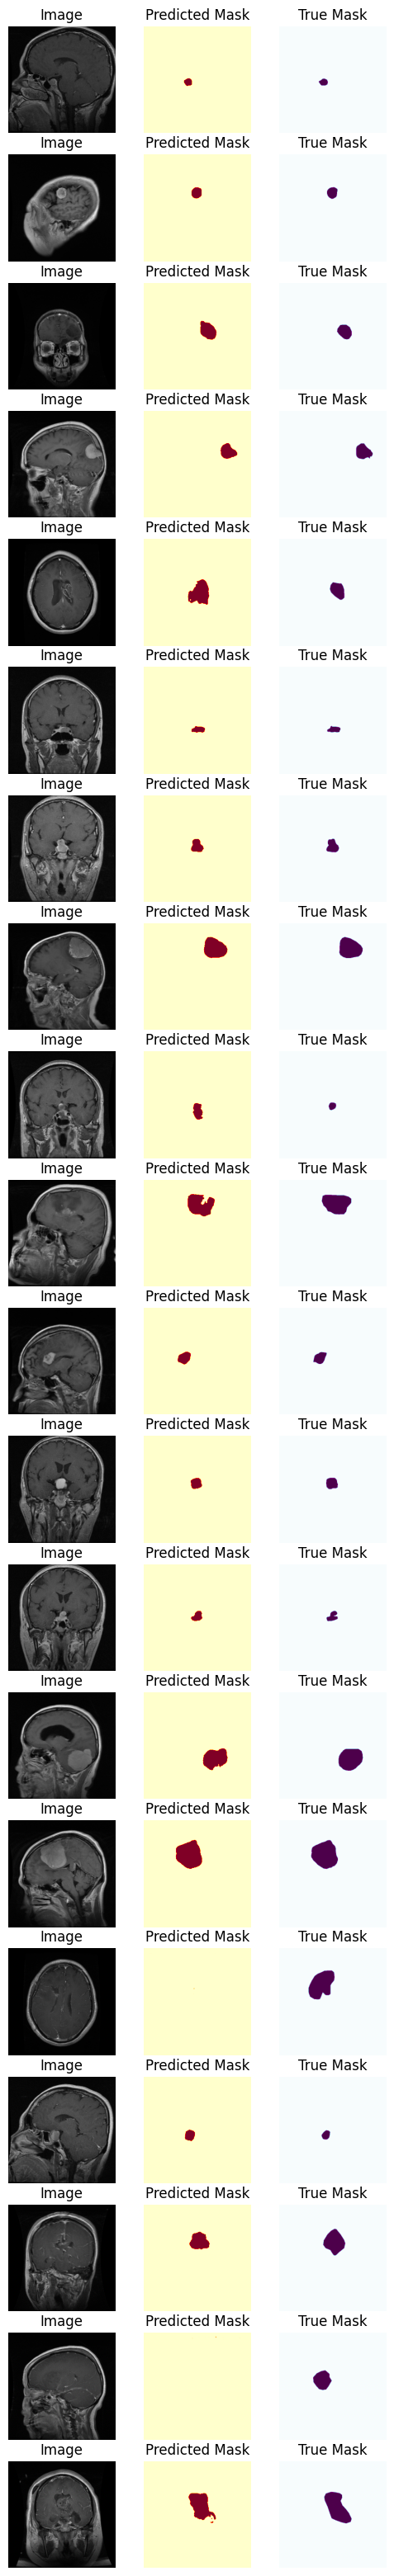

In [33]:
num_samples = 20  # Specify the number of samples you want to visualize

visualization_dataset = test_dataset.take(num_samples)
plt.figure(figsize=(6, 2 * num_samples))
# Assuming valid_dataset provides tuples (image, mask)
for counter, (img_data, true_mask) in enumerate(visualization_dataset):
    # Expand dimensions if necessary (e.g., for grayscale images)
    # true_mask = np.expand_dims(true_mask, -1)

    # Make predictions
    prediction = model.predict(img_data)
    no_of_batch = np.random.randint(0, 2, 1)
    print(no_of_batch)

    # Plotting
    plt.subplot(num_samples, 3, 3 * counter + 1)
    plt.imshow(img_data[no_of_batch[0]])  # Accessing the first element in the batch
    plt.title("Image")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3 * counter + 2)
    plt.imshow(prediction[no_of_batch[0]], cmap='YlOrRd')  # Change the colormap here
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(num_samples, 3, 3 * counter + 3)
    plt.imshow(true_mask[no_of_batch[0]], cmap='BuPu')  # Change the colormap here
    plt.title('True Mask')
    plt.axis('off')

plt.show()
